In [4]:
# Importing some packages
import os
os.chdir("/Users/ieo5776/Desktop/Garmin_analysis/")

import sys
from typing import Any, Dict, List, Union
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import garth
from garth.exc import GarthException
import seaborn as sns
from scipy import stats

# custom functions
from utils import sleep_functions

# To Do List

1) General analysis on sleep data.
2) focus on an average month vs August for sleep quality
3) Predict sleep score based on the individual scores of each night, i don't think they do it like that but let's see

In [5]:
# Check if connection is still valid, otherwise ask for credentials
GARTH_HOME = "/Users/ieo5776/Desktop/Garmin_analysis"

from garth.exc import GarthException
from getpass import getpass

try:
    garth.resume(GARTH_HOME)
    garth.client.username
except (GarthException, FileNotFoundError):
    email = input("Email: ")
    password = getpass("Password: ")
    garth.client.login(email, password)

garth.save(GARTH_HOME)

#garth.resume("~/.garth")

In [ ]:
#garth.connectapi("/userprofile-service/userprofile/user-settings")
#garth.UserSettings.get()
#garth.connectapi("/userprofile-service/socialProfile")
#camel_to_snake_dict(garth.connectapi("/userprofile-service/userprofile/user-settings"))

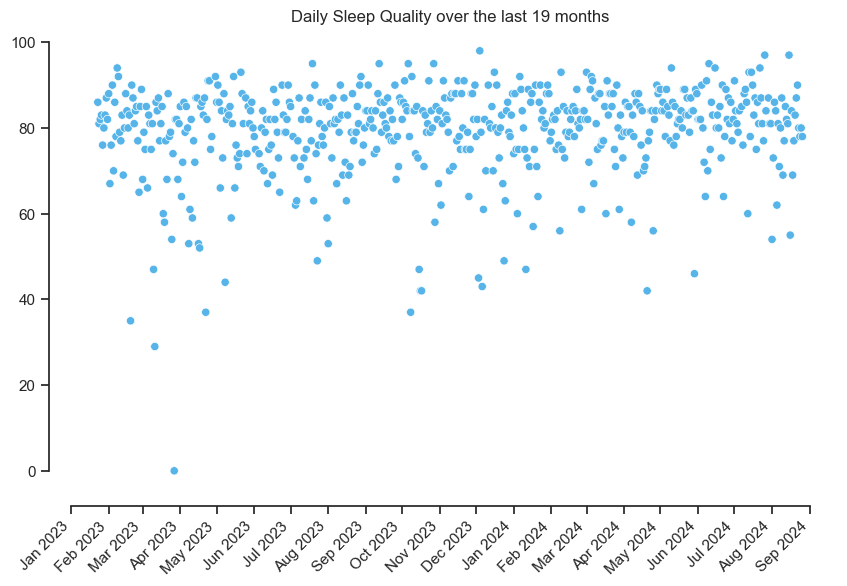

In [6]:
daily_sleep = pd.DataFrame(garth.DailySleep.list(period=365*2))

daily_sleep["calendar_date"] = pd.to_datetime(daily_sleep["calendar_date"])
daily_sleep.set_index("calendar_date", inplace=True)

sleep_functions.plt_sleep(daily_sleep)

In [7]:
latest = garth.DailySleep.list(period=2)[-1].calendar_date
sleep_data = [sd.daily_sleep_dto for sd in garth.SleepData.list(latest, 365+(int(365/2)))]

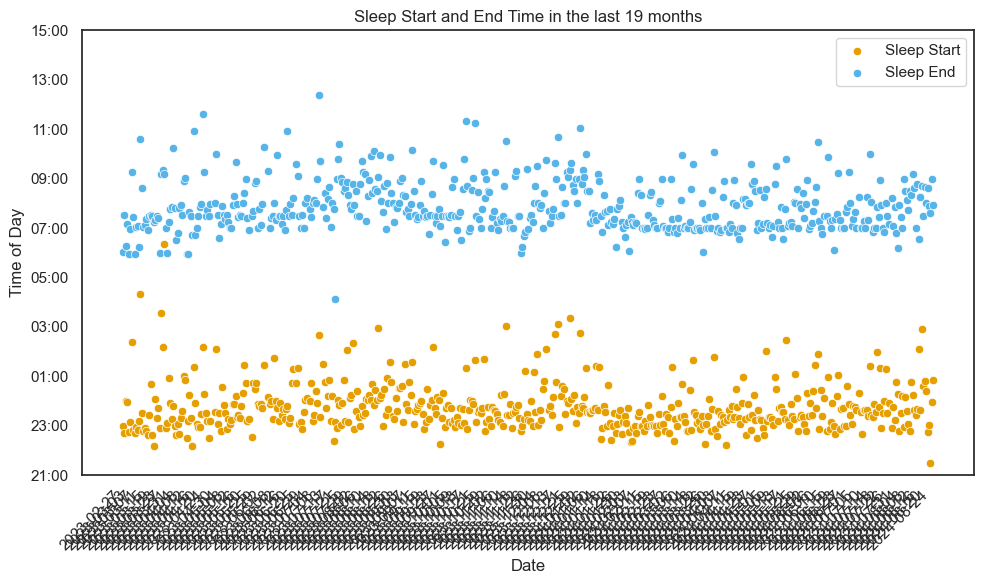

In [20]:
df = pd.DataFrame(sleep_data)
df.sort_values("calendar_date", inplace=True)
df.set_index("calendar_date", inplace=True)

# Convert index to datetime
df.index = pd.to_datetime(df.index)

# Get the provided timestamp columns (in milliseconds)
start_col = "sleep_start_timestamp_local"
end_col = "sleep_end_timestamp_local"

# Convert the timestamps (in milliseconds) to hours and minutes
df["sleep_start_time"] = pd.to_datetime(df[start_col], unit="ms").dt.time
df["sleep_end_time"] = pd.to_datetime(df[end_col], unit="ms").dt.time


df["sleep_start_hours"] = df["sleep_start_time"].apply(convert_time)
df["sleep_end_hours"] = df["sleep_end_time"].apply(convert_time)


# Plot
plt.figure(figsize=(10, 6))
#sns.lineplot(data=df, x=df.index, y="sleep_start_hours", label="Sleep Start", marker="o")
sns.scatterplot(x=df.index, y=df["sleep_start_hours"], label="Sleep Start",color=["#E69F00"])
#sns.lineplot(data=df, x=df.index, y="sleep_end_hours", label="Sleep End", marker="o")
sns.scatterplot(x=df.index, y=df["sleep_end_hours"], label="Sleep End", color=["#56B4E9"])

# Formatting
plt.title("Sleep Start and End Time in the last 19 months")
plt.ylabel("Time of Day")
plt.xlabel("Date")
#plt.grid(axis="x")
plt.xticks(df.index[::4], rotation=45, ha="right")
plt.yticks(range(0, 24, 2), [f"{(h + 21) % 24:02d}:00" for h in range(0, 24, 2)])
plt.ylim(0, 18)
plt.tight_layout()
plt.legend()
plt.show()